# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
3951       Data Analyst - Stitching   
11835     Navision Business Analyst   
6373                  Data Engineer   
11561        Branch Analyst Program   
2230                   Data Analyst   
7668       Remote Software Engineer   
9128       Business Systems Analyst   
10905        Mid All Source Analyst   
5581   Data Analyst - Public Sector   
2887          Senior Data Scientist   

                                         Job Description  \
3951   OverviewAt Perficient you'll deliver mission-c...   
11835  Hi, Role Navision Business Analyst Location Su...   
6373   About codeSpark\ncodeSpark is turning programm...   
11561  POSITION SUMMARY:Individuals are placed in one...   
2230   What you'll be doing:The Data Analyst uses adv...   
7668   Software EngineerLocation: Remote\n\nWe cannot...   
9128   Contract to Hire Position 5+ years professiona...   
10905  *This position is contingent upon government f...   
5581   Conducts or participates in meetings with owne...   
2887   Vectra Networks delivers a new class of advanc...   

                           Company Name         Location         City State  \
3951                         Perficient     New York, NY     New York    NY   
11835                     Sensiple Inc.    Sunnyvale, CA    Sunnyvale    CA   
6373                          codeSpark     Pasadena, CA     Pasadena    CA   
11561                    Morgan Stanley       Dallas, TX       Dallas    TX   
2230               Tandem Diabetes Care    San Diego, CA    San Diego    CA   
7668                    TEKsystems, Inc    San Diego, CA    San Diego    CA   
9128         Pacific Technical Staffing    Fullerton, CA    Fullerton    CA   
10905  Clear Resolution Consulting, LLC  San Antonio, TX  San Antonio    TX   
5581                         Sense Corp       Austin, TX       Austin    TX   
2887                             Vectra     San Jose, CA     San Jose    CA   

          Remote          Size  Founded                             Industry  \
3951   Uncertain  Medium-Large   1998.0                          IT Services   
11835  Uncertain        Medium   1999.0                          IT Services   
6373   Uncertain    Very Small      NaN                       K 12 Education   
11561  Uncertain    Very Large   1935.0  Investment Banking Asset Management   
2230         Yes  Medium-Large   2006.0   Health Care Products Manufacturing   
7668         Yes  Medium-Large   1983.0                 Staffing Outsourcing   
9128         Yes           NaN      NaN                                  NaN   
10905  Uncertain         Small   2008.0                    Aerospace Defense   
5581   Uncertain  Medium-Small   1996.0                           Accounting   
2887   Uncertain         Small      NaN                           Accounting   

       Rating  SalaryMin  SalaryMax  Salary Estimate   DF  
3951      3.6         51         88             69.5  DF1  
11835     3.3         98        172            135.0  DF1  
6373      NaN         95        167            131.0  DF1  
11561     3.8         47         88             67.5  DF1  
2230      3.6         83        165            124.0  DF1  
7668      3.9        191        217            204.0  DF1  
9128      NaN         77        151            114.0  DF1  
10905     4.5         35         65             50.0  DF1  
5581      3.8         35         42             38.5  DF1  
2887      2.8        111        175            143.0  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
3898            Software Engineer - Senior Data Analyst   
1458                              CLINICAL DATA ANALYST   
1003                           Informatica Data Modeler   
1219                               Senior Data Engineer   
209                                      Data Scientist   
1274                                   Sr. Data Analyst   
3447  Quantum Principal Data Scientist- Industrial D...   
2035                                Senior Data Analyst   
2969            Principal Data Scientist- Public Sector   
2160                                      Data Engineer   

                                        Job Description  \
3898  As a member of our Software Engineering Group,...   
1458  Envision Physician Services is a multispecialt...   
1003  Role : Informatica Data Modeler\nLocation: Chi...   
1219  LyondellBasell (NYSE: LYB) is one of the large...   
209   One of the world’s leading financial consultat...   
1274  Position Title: Sr. Data Analyst\nReporting Ma...   
3447  IntroductionAs a Data Scientist at IBM, you wi...   
2035  Job Description (Posting).* Develop, implement...   
2969  *Introduction**As a Data Scientist at IBM, you...   
2160  Do you believe that people with compassion wil...   

                          Company Name         Location         City State  \
3898         JPMorgan Chase Bank, N.A.     Columbus, OH     Columbus    OH   
1458               Envision Healthcare      Phoenix, AZ      Phoenix    AZ   
1003                         Avanciers      Chicago, IL      Chicago    IL   
1219         LyondellBasell Industries      Houston, TX      Houston    TX   
209                          Prolancer     New York, NY     New York    NY   
1274  Texas Dow Employees Credit Union   Sugar Land, TX   Sugar Land    TX   
3447                   IBM Corporation       Austin, TX       Austin    TX   
2035             HCL Technologies Ltd.  San Antonio, TX  San Antonio    TX   
2969                               IBM     San Jose, CA     San Jose    CA   
2160                         CrowdRise    San Diego, CA    San Diego    CA   

         Remote          Size  Founded                               Industry  \
3898  Uncertain    Very Large   1799.0  Investment Banking & Asset Management   
1458  Uncertain    Very Large   2005.0       Health Care Services & Hospitals   
1003  Uncertain    Very Small   2015.0                            IT Services   
1219  Uncertain    Very Large   2007.0                 Chemical Manufacturing   
209         Yes    Very Small      NaN                                    NaN   
1274  Uncertain        Medium   1955.0                  Banks & Credit Unions   
3447  Uncertain    Very Large   1911.0                            IT Services   
2035  Uncertain    Very Large   1991.0           Computer Hardware & Software   
2969  Uncertain    Very Large   1911.0                            IT Services   
2160  Uncertain  Medium-Small   2010.0                               Internet   

      Rating SalaryMin SalaryMax  Salary Estimate   DF  
3898     3.9        55      112               NaN  DF2  
1458     3.0        64       97               NaN  DF2  
1003     3.9        60      105               NaN  DF2  
1219     3.7       138      217               NaN  DF2  
209      5.0       119      147               NaN  DF2  
1274     3.1        73      136               NaN  DF2  
3447     3.7        74      144               NaN  DF2  
2035     3.5        83      154               NaN  DF2  
2969     3.7       150      237               NaN  DF2  
2160     4.5       114      146               NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
87                             Customer Data Scientist   
192               Principal Scientist, GxP Bioanalysis   
302  Research Scientist or Principal Research Scien...   
676                                     Data Scientist   
502                              Clinical Data Manager   
200                                     Data Scientist   
305  Sr. Scientist/Sr. Engineer II, Process Develop...   
226                                       Data Analyst   
219                      Scientist I, Biomanufacturing   
389         Senior Principal Data Scientist (Python/R)   
543                                     Data Scientist   
785                    Data Engineer (Multiple Levels)   
584                                     Data Scientist   
203                          Data Scientist - Contract   
833                                     Data Scientist   
14                       Analytics Manager - Data Mart   
830                           Data Scientist Assistant   
620                                     Data Scientist   
282                         Sr. Manager, Data Engineer   
445                                     Data Scientist   

                                       Job Description  \
87   Company Overview\n\nH2O.ai is the open source ...   
192  Job Description Summary:\nThe Principal Scient...   
302  Mitsubishi Electric Research Laboratories (MER...   
676  Headquartered in Lynchburg, Va., BWX Technolog...   
502  At Alector, our mission is to develop therapie...   
200  About MuteSix:\n\nMuteSix, an iProspect compan...   
305  The Role:\n\nModerna is seeking a highly motiv...   
226  Data Analyst\n\n\n\nAddThis Sharing Buttons\nS...   
219  Aldevron is seeking a Scientist I, Biomanufact...   
389  Roche Diagnostics has built a new strategic ar...   
543  Data Scientist\n\n\nat Brightidea\nSan Francis...   
785  Purpose of Job\nWe are currently seeking talen...   
584  The opportunity\n\n\nGrammarly empowers people...   
203  We are an ambitious, well-funded startup with ...   
833  Job TITLE: Data Scientist\n\nLocation: Santa C...   
14   We have an opportunity to join the Alliance as...   
830  Overview\n\n\nEstablished in 1946, the America...   
620  Role Data Scientist Location Seattle, WA Durat...   
282  West Creek 4 (12074), United States of America...   
445  Location: Anywhere in the US or Canada | Locat...   

                               Company Name                 Location  \
87                                   h2o.ai        Mountain View, CA   
192                  PTC Therapeutics, Inc.     South Plainfield, NJ   
302       Mitsubishi Electric Research Labs            Cambridge, MA   
676                        BWX Technologies            Oak Ridge, TN   
502                                 Alector  South San Francisco, CA   
200                                 MuteSix          Los Angeles, CA   
305                    Moderna Therapeutics              Norwood, MA   
226                         CALIBRE Systems           Alexandria, VA   
219                                Aldevron              Madison, WI   
389                                   Roche          Santa Clara, CA   
543                              Brightidea        San Francisco, CA   
785                                    USAA                Plano, TX   
584                               Grammarly        San Francisco, CA   
203                  Upside Business Travel                   Remote   
833                                 Flexton          Santa Clara, CA   
14   Central California Alliance for Health        Scotts Valley, CA   
830        American Institutes for Research           Washington, DC   
620                             OrbITpeople              Seattle, WA   
282                             Capital One             Richmond, VA   
445                              TA Digital             New York, NY   

                    City State     Remote          Size  Founded  \
87         Mountain View  

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
1943                          Data Analyst - Health   
1347                                   Data Analyst   
875   IT Risk and Compliance Data Reporting Analyst   
1680                Celonis Data Engineer & Analyst   
1493         Data Analyst with Data Mapping and API   
1289        Data Analyst III (Healthcare Analytics)   
75       Information Systems Officer (Data Analyst)   
1291              Automotive eCommerce Data Analyst   
1113                         Data Analyst/Architect   
1253                                   Data Analyst   

                                        Job Description  \
1943  Overview\n\nIMPAQ International, a growing and...   
1347  Financial Additions has partnered with a lead ...   
875   Job Description\nReporting to the Supervisor, ...   
1680  About The Client\nThe company specializes in D...   
1493  Role Name System AnalystData Analyst Location ...   
1289  Professional\n\nPosition Purpose:\nAnalysis an...   
75    Org. Setting and Reporting\n\nThe United Natio...   
1291  Automotive eCommerce Data Analyst\n\nThe Compa...   
1113  : Responsible for designing, modeling, develop...   
1253  Job Description\nJob Title: Data Analyst\nLoca...   

                  Company Name          Location          City State  \
1943  Impaq International, Llc       Oakland, CA       Oakland    CA   
1347       Financial Additions        Dallas, TX        Dallas    TX   
875                 TalentDash       Chicago, IL       Chicago    IL   
1680               SNIPEBRIDGE        Austin, TX        Austin    TX   
1493          Xcutives.com Inc      San Jose, CA      San Jose    CA   
1289       Centene Corporation     San Diego, CA     San Diego    CA   
75              United Nations      New York, NY      New York    NY   
1291          Web Shop Manager     San Diego, CA     San Diego    CA   
1113                   TechUSA  Philadelphia, PA  Philadelphia    PA   
1253      Conflux Systems Inc.     San Diego, CA     San Diego    CA   

         Remote          Size  Founded  \
1943  Uncertain  Medium-Small   2001.0   
1347  Uncertain    Very Small   1999.0   
875   Uncertain    Very Small   2014.0   
1680  Uncertain           NaN      NaN   
1493  Uncertain           NaN      NaN   
1289  Uncertain    Very Large   1984.0   
75    Uncertain    Very Large   1945.0   
1291        Yes    Very Small   2000.0   
1113  Uncertain  Medium-Large   1998.0   
1253  Uncertain    Very Small      NaN   

                                     Industry  Rating SalaryMin SalaryMax  \
1943                               Consulting     3.4        93      159    
1347    Investment Banking & Asset Management     4.6        30       53    
875   Enterprise Software & Network Solutions     NaN        68       87    
1680                                      NaN     NaN        53      104    
1493                                      NaN     NaN       110      190    
1289                       Insurance Carriers     3.3        60      124    
75                           Federal Agencies     4.1        51       88    
1291             Computer Hardware & Software     4.2        60      124    
1113                   Staffing & Outsourcing     2.7        38       68    
1253                               Accounting     4.5        76      122    

      Salary Estimate  DF  
1943              NaN  DA  
1347              NaN  DA  
875               NaN  DA  
1680              NaN  DA  
1493              NaN  DA  
1289              NaN  DA  
75                NaN  DA  
1291              NaN  DA  
1113              NaN  DA  
1253              NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
2163  Big Data Developer/ Big Data Software Engineer...   
2205                                      Data Engineer   
2152          Data Systems Engineer/Informaticist (ESA)   
2333         Senior Business Intelligence (BI) Engineer   
1616                                      Data Engineer   
2433                           Senior Big Data Engineer   
93                                        Data Engineer   
1854                                      Data Engineer   
2157                                  Big Data Engineer   
1509                                  Sr. Data Engineer   

                                        Job Description  \
2163  Title: Big Data Developer/ Big Data Software E...   
2205  Title Data Engineer Location Jacksonville, FL ...   
2152  Job Posting Title:\n\nData Systems Engineer/In...   
2333  WHY VARIDESK:\nComprehensive Health Plans\nHea...   
1616  Role Developer - Data Engineer Location Irving...   
2433  HMS makes the healthcare system work better fo...   
93    Job DescriptionDesign, build and maintain high...   
1854  At CrowdStrike we’re on a mission - to stop br...   
2157  You must have Strong knowledge Good knowledge ...   
1509  Responsibilities:\n\n\nPrimary responsibilitie...   

                           Company Name          Location          City State  \
2163                    Georgia IT Inc.        Austin, TX        Austin    TX   
2205                        TekPartners  Jacksonville, FL  Jacksonville    FL   
2152      Applied Research Laboratories        Austin, TX        Austin    TX   
2333                           VARIDESK       Coppell, TX       Coppell    TX   
1616  Object Technology Solutions, Inc.        Irving, TX        Irving    TX   
2433                       HMS Holdings        Irving, TX        Irving    TX   
93      American Modern Insurance Group      New York, NY      New York    NY   
1854                        CrowdStrike     Sunnyvale, CA     Sunnyvale    CA   
2157            Lorven Technologies Inc        Austin, TX        Austin    TX   
1509                          Broadwing     Encinitas, CA     Encinitas    CA   

         Remote          Size  Founded  \
2163        Yes    Very Small      NaN   
2205  Uncertain        Medium   2002.0   
2152  Uncertain        Medium      NaN   
2333  Uncertain  Medium-Small   2013.0   
1616  Uncertain         Small   1999.0   
2433  Uncertain  Medium-Large   1974.0   
93    Uncertain           NaN   1994.0   
1854        Yes  Medium-Large   2011.0   
2157  Uncertain    Very Small      NaN   
1509  Uncertain    Very Small   2018.0   

                                     Industry  Rating SalaryMin SalaryMax  \
2163                                      NaN     5.0        82       130   
2205                   Staffing & Outsourcing     4.3        27       50    
2152                  Colleges & Universities     3.8        67      126    
2333                      Other Retail Stores     3.9        65      120    
1616                              IT Services     4.0        64      124    
2433         Health Care Services & Hospitals     3.8       100      160    
93                         Insurance Carriers     3.5        85      154    
1854  Enterprise Software & Network Solutions     4.0       164      192    
2157                               Accounting     4.0        67      126    
1509                   Staffing & Outsourcing     NaN        79      132    

      Salary Estimate  DF  
2163              NaN  DE  
2205              NaN  DE  
2152              NaN  DE  
2333              NaN  DE  
1616              NaN  DE  
2433              NaN  DE  
93                NaN  DE  
1854              NaN  DE  
2157              NaN  DE  
1509              NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
10                                     STAFF SCIENTIST   
762                                Senior Data Analyst   
489  Research Scientist (Machine Learning and Artif...   
784  Data Analytics Engineer-Business Intelligence ...   
785       Data Engineer (Active TS SCI with Polygraph)   
237                   Temporary Marketing Data Analyst   
102                              Data Scientist BSLEF8   
575                                     Data Scientist   
598                                     Data Scientist   
302                                     Data Scientist   

                                       Job Description  \
10   Position: Staff Scientist\n\nRequisition Numbe...   
762  Overview\n\n\nCompany Overview:\n\nGuided by a...   
489  Title: Research Scientist (Machine Learning an...   
784  Analytics Engineer-Clinical Services\nSumma He...   
785  Volume Integration, LLC partners with our cust...   
237  Job Description Summary:\n\nWe have a temporar...   
102  E3/Sentinel’s Homeland Security Enterprise (HS...   
575  Requisition ID: 255385\nWork Area: Software-Re...   
598  Job Description\n\n\nAre you looking for a new...   
302  This role entails an opportunity to understand...   

                 Company Name           Location           City State  \
10                 S&ME, Inc.    Chattanooga, TN    Chattanooga    TN   
762           Ability Network    Minneapolis, MN    Minneapolis    MN   
489  Samsung Research America  Mountain View, CA  Mountain View    CA   
784       Summa Health System          Akron, OH          Akron    OH   
785   Volume Integration, LLC         Reston, VA         Reston    VA   
237            Fenwick & West  Mountain View, CA  Mountain View    CA   
102      E3 Federal Solutions     Alexandria, VA     Alexandria    VA   
575                       SAP      Palo Alto, CA      Palo Alto    CA   
598              Salient CRGT      Arlington, VA      Arlington    VA   
302                      eBay       San Jose, CA       San Jose    CA   

        Remote          Size  Founded  \
10   Uncertain  Medium-Large   1973.0   
762  Uncertain  Medium-Small   2000.0   
489  Uncertain  Medium-Large   1988.0   
784  Uncertain         Large   1926.0   
785  Uncertain         Small   2013.0   
237  Uncertain        Medium   1972.0   
102  Uncertain        Medium   2004.0   
575  Uncertain    Very Large   1972.0   
598  Uncertain  Medium-Large      NaN   
302  Uncertain    Very Large   1995.0   

                                    Industry  Rating SalaryMin SalaryMax  \
10      Architectural & Engineering Services     3.6        78      133    
762             Computer Hardware & Software     2.9       109      153    
489             Computer Hardware & Software     3.7        86      143    
784         Health Care Services & Hospitals     3.5        76      127    
785                      Aerospace & Defense     4.4        76      127    
237                                    Legal     4.0       134      213    
102                               Consulting     4.4       150      169    
575             Computer Hardware & Software     4.6        74      127    
598  Enterprise Software & Network Solutions     3.2        48       89    
302                                 Internet     3.6        89      148    

     Salary Estimate  DF  
10               NaN  DS  
762              NaN  DS  
489              NaN  DS  
784              NaN  DS  
785              NaN  DS  
237              NaN  DS  
102              NaN  DS  
575              NaN  DS  
598              NaN  DS  
302              NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
22255               Sr. Data Governance Business Analyst   
26393                                Member Data Analyst   
5235                            Analyst I, Data & Design   
17519                               Data Science Manager   
8524                                   Drainage Engineer   
14069                                      Data Engineer   
830    IoT Data Scientist - Leadeship Role - Chicago,...   
18399                                      Data Engineer   
11770                                  Program Analyst I   
11774                                   Business Analyst   
8510                     Data Engineer (Big Data Hadoop)   
4245     Sr Business Data Analyst SAP, SKU, Supply Chain   
16898                                     Data Scientist   
22960                     Data Quality Analyst - Spanish   
19393                          Machine Learning Engineer   
23011                              Business Data Analyst   
18950                       Staff Data Software Engineer   
7034                                   Big Data Engineer   
13211                      Business Intelligence Analyst   
19972  PwC Labs - Senior Data Scientist - Machine Lea...   

                                         Job Description  \
22255  At least 5 years’ experience working on core D...   
26393  Blue Federal Credit Union employees work hard,...   
5235   MAJOR RESPONSIBILITIES:\nDevelop and implement...   
17519  As a Data Science Manager, you will lead one o...   
8524   Req ID: 17105\nFor more than 50 years, TranSys...   
14069  Join a team of financial software specialists ...   
830    Work in a collaborative environment with globa...   
18399  Create data pipelines to include ETL and strea...   
11770  *Program Analyst I**\n*Description**\n*AGS,LLC...   
11774  Business Analyst\nBusinessAnalyst\nKey Qualifi...   
8510   bull Analyze and understand data sources APIs ...   
4245   Business Data Analyst - long term consulting r...   
16898  Job Description and Responsibilities\n\nIntera...   
22960  Company Overview\n\nLodestone is a best of bre...   
19393  Develop data set processes for data modeling, ...   
23011  About Pushnami\n\nDelivering more than 10 bill...   
18950  Strong data modeling skills, including data wa...   
7034   Role: Big Data Engineer\n\nLocation: Phoenix, ...   
13211  Job Brief\n\nSeasoned and motivated Senior Bus...   
19972  Utilizing and applying knowledge commonly used...   

                             Company Name           Location           City  \
22255                       Carnegie Soft        Chicago, IL        Chicago   
26393           Blue Federal Credit Union       Cheyenne, WY       Cheyenne   
5235   Dallas Independent School District         Dallas, TX         Dallas   
17519                                Yelp  San Francisco, CA  San Francisco   
8524                          Transystems     Fort Worth, TX     Fort Worth   
14069       STEVENS CAPITAL MANAGEMENT LP         Radnor, PA         Radnor   
830                             Capgemini        Chicago, IL        Chicago   
18399          Remedy BPCI Partners, LLC.       New York, NY       New York   
11770                                nana       San Jose, CA       San Jose   
11774                     IT Trailblazers      Sunnyvale, CA      Sunnyvale   
8510    Object Technology Solutions, Inc.         Irving, TX         Irving   
4245                             EVERSANA       New York, NY       New York   
16898                 Interactive Brokers      Greenwich, CT      Greenwich   
22960                           Lodestone     Menlo Park, CA     Menlo Park   
19393                          ActZero.ai        Seattle, WA        Seattle   
23011                            Pushnami         Austin, TX         Austin   
18950                              Namely       New York, NY       New York   
7034                         Diverse Lynx        Phoenix, AZ        Phoenix   
13211                   

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
# criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
# duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

criteria=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FullDataSet.drop_duplicates(subset=criteria, keep='last', inplace=True)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
#! pip install contractions
#nltk.download('all')

In [15]:
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 


FullDataSet['edit_jobDescription']=FullDataSet['Job Description'].dropna().apply(lambda x: editor(x))
FullDataSet

Job Title  \
1712                                       Data Engineer   
2144   Research Scientist, Structural Biologist - Cry...   
3078            Principal Data Scientist, Bioinformatics   
7143                                Senior Data Engineer   
8653    Business Analyst - Clinical & Logistics Platform   
...                                                  ...   
27040              Big Data Analytics, Security Engineer   
27041                                     Data Scientist   
27042                  Data Scientist with Active Secret   
27043                   Senior Machine Learning Engineer   
27044                  Data Scientist - TS/SCI with Poly   

                                         Job Description  \
1712   Data Engineer in Philadelphia, PA 19103\n\nInt...   
2144   Vertex Pharmaceuticals is seeking a highly mot...   
3078   At Roche Sequencing Solutions, we are driven t...   
7143   Description: Leads and participates in the des...   
8653   Company Overview\n\n\nAt Memorial Sloan Ketter...   
...                                                  ...   
27040  What does a great Big Data Analytics, Security...   
27041  Title: Data Scientist @ Springfield, VA\nTerms...   
27042  Responsibilities include:\n- Support a team of...   
27043  With the continued impact of COVID-19 and soci...   
27044  Data Scientist - TS/SCI with Poly\nClearance L...   

                      Company Name          Location          City State  \
1712           Turnberry Solutions  Philadelphia, PA  Philadelphia    PA   
2144        Vertex Pharmaceuticals     San Diego, CA     San Diego    CA   
3078                         Roche   Santa Clara, CA   Santa Clara    CA   
7143                         Aetna     Blue Bell, PA     Blue Bell    PA   
8653      Memorial Sloan-Kettering      New York, NY      New York    NY   
...                            ...               ...           ...   ...   
27040                       Fiserv   Jersey City, NJ   Jersey City    NJ   
27041                       CEDENT   Springfield, VA   Springfield    VA   
27042  Maania Consultancy Services        Dulles, VA        Dulles    VA   
27043                       Kensho     Cambridge, MA     Cambridge    MA   
27044                     Coverent        McLean, VA        McLean    VA   

          Remote          Size  Founded                          Industry  \
1712   Uncertain        Medium   2001.0                       IT Services   
2144   Uncertain  Medium-Large   1989.0           Biotech Pharmaceuticals   
3078   Uncertain    Very Large   1896.0           Biotech Pharmaceuticals   
7143   Uncertain    Very Large   1853.0                Insurance Carriers   
8653         Yes    Very Large   1884.0    Health Care Services Hospitals   
...          ...           ...      ...                               ...   
27040  Uncertain    Very Large   1984.0  Financial Transaction Processing   
27041  Uncertain    Very Small      NaN      Computer Hardware & Software   
27042  Uncertain    Very Small      NaN                               NaN   
27043        Yes         Small   2013.0                          Internet   
27044  Uncertain         Small   2008.0                        Consulting   

       Rating  SalaryMin  SalaryMax  Salary Estimate  Hourly  Junior  Senior  \
1712      4.6        NaN        NaN            130.0   False     NaN     NaN   
2144      3.3        NaN        NaN             92.0   False     NaN     NaN   
3078      4.1        NaN        NaN            159.5   False     NaN     NaN   
7143      3.3        NaN        NaN             83.0   False     NaN     NaN   
8653      3.9        NaN        NaN             79.0   False     NaN     NaN   
...       ...        ...        ...              ...     ...     ...     ...   
27040     3.1       64.0      117.0              NaN   False     NaN     NaN   
27041     NaN       64.0      117.0              NaN   False     NaN     NaN   
27042     4.6       64.0      117.0            

In [16]:
#commonWords=['provide', 'experience', 'include', 'year', 'business', 'work', 'equal', 'opportunity', 'skill', 'national', 'sexual', 'orientation', 'gender', 'identity']
def common(x):
    x=x.lower()
    replaced=r'''(provide|experience|include|year|business|work|equal|opportunity|skill|national|
    sexual|orientation|gender|identity|race|color|join|role|skill|task|duty|job| 
    description|use|require|ability|company|data|science|scientist|engineer)'''
    x=re.sub(replaced, ' ',x)
    return x

FullDataSet['edit_jobDescription']=FullDataSet['edit_jobDescription'].dropna().apply(lambda x: common(x))

In [17]:
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning Scientist"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI Engineer"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning Engineer"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 



FullDataSet['edit_jobTitle']=FullDataSet['Job Title'].dropna().apply(lambda x: fixTitle(x))
FullDataSet['edit_jobTitle']

1712                 Data Engineer
2144                Data Scientist
3078                Data Scientist
7143                 Data Engineer
8653              Business Analyst
                   ...            
27040                     Big Data
27041               Data Scientist
27042               Data Scientist
27043    Machine Learning Engineer
27044               Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [18]:
FullDataSet.to_csv('FullDataSet.csv')

In [19]:
uniqueJobTitles=FullDataSet.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence' 'Sales'
 'Workforce Analyst' 'Cyber Security' 'Researcher' 'Scientist'
 'Data Modeler' 'Data Architect' 'Research Scientist'
 'Machine Learning Scientist' 'Developer' 'Applied Scientist'
 'Machine Learning Engineer' 'Big Data' 'Environmental Scientist'
 'AI Engineer' 'Clinical Scientist' 'Computer Scientist' 'Engineer'
 'Medical Scientist' 'Product Manager' 'Systems Engineer'
 'Research Engineer' 'Machine Learning' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
36


In [20]:
profile = pp.ProfileReport(FullDataSet.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data Engineer


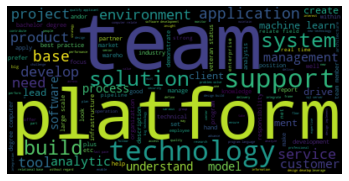



Data Scientist


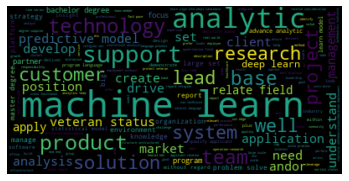



Business Analyst


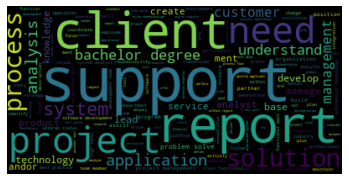



Analyst


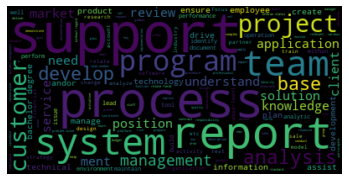



Data Analyst


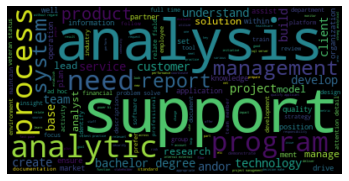

In [21]:
from wordcloud import WordCloud

# jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'AI',
#  'Data Analyst', 'Intern', 'Consultant', 'Business Intelligence', 'Sales',
#  'Workforce Analyst' ,'Cyber Security' ,'Researcher', 'Scientist',
#  'Data Modeler', 'Data Architect', 'Research Scientist',
#  'Machine Learning Scientist', 'Developer', 'Applied Scientist',
#  'Machine Learning Engineer', 'Big Data', 'Environmental Scientist',
#  'AI Engineer', 'Clinical Scientist', 'Computer Scientist', 'Engineer',
#  'Medical Scientist', 'Product Manager', 'Systems Engineer',
#  'Research Engineer', 'Machine Learning', 'Software Engineer',
#  'Applications Engineer', 'Cloud Engineer', 'Full Stack Engineer']


def fun(x):
    
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']
FullDataSet.loc[FullDataSet['edit_jobTitle']==jt[4]]

for job in jt:
    wordList=[]
    FullDataSet.loc[FullDataSet['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)

        # Display the generated image:
        # the matplotlib way:

        
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    print(job)
    plt.show()
    print("\n")

Data Engineer


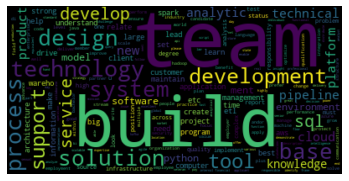



Data Scientist


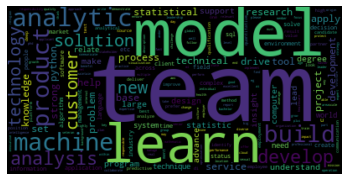



Business Analyst


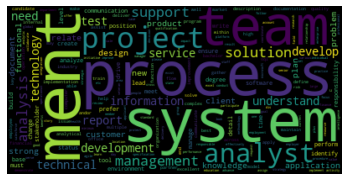



Analyst


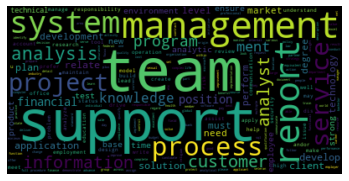



Data Analyst


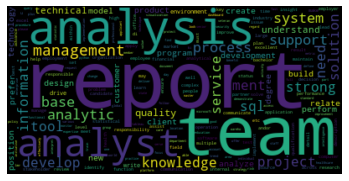

In [22]:
for job in jt:
    wordList=[]
    FullDataSet.loc[FullDataSet['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))
    abc=" ".join(wordList)
    wordcloud = WordCloud(collocations=False).generate(abc)

        # Display the generated image:
        # the matplotlib way:

        
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    print(job)
    plt.show()
    print("\n")

In [23]:
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))

In [24]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())

1299.0
252.0
1042.0


In [25]:
FullDataSet[FullDataSet['temp']==1]

Job Title  \
8678   Operations Regulatory Control Change Lead Busi...   
8682                                    Business Analyst   
8684                                    Business Analyst   
8700                                    Business Analyst   
8711                                 Entry Level Analyst   
...                                                  ...   
26958                                     Data Scientist   
26979                                     Data Scientist   
26982  Senior Associate Scientist - Clinical & Diagno...   
27003     Machine Learning Engineer Virtual Hiring Event   
27004                                     Data Scientist   

                                         Job Description  \
8678   The Operations Regulatory Control (ORC) Change...   
8682   iHeartMedia is the number one audio company in...   
8684   Required:\n1. Bachelor's Degree in Information...   
8700   Job Description\nBusiness Analyst\nAnalyzes an...   
8711   Are you about to graduate and get your career ...   
...                                                  ...   
26958  About Seneca Resources:\nSeneca Resources is c...   
26979  We are data detectives and our job is difficul...   
26982  Why Patients Need You\n\n\nPfizer’s purpose is...   
27003  SAP Hiring Event!\n\nEvent Details\nDate: Tues...   
27004  Data Scientist (Big Data)\n\nLocation: Philade...   

                           Company Name           Location           City  \
8678                               Citi       New York, NY       New York   
8682                        iHeartRadio       New York, NY       New York   
8684   Crossfire Consulting Corporation       New York, NY       New York   
8700                  Black Systems LLC       New York, NY       New York   
8711             Phyton Talent Advisors       New York, NY       New York   
...                                 ...                ...            ...   
26958                  Seneca Resources        Norfolk, VA        Norfolk   
26979                         Q Systems      Palo Alto, CA      Palo Alto   
26982                            Pfizer    Pearl River, NY    Pearl River   
27003                               SAP  Newport Beach, CA  Newport Beach   
27004              Computer Enterprises   Philadelphia, PA   Philadelphia   

      State     Remote          Size  Founded  \
8678     NY  Uncertain    Very Large   1812.0   
8682     NY  Uncertain    Very Large   1972.0   
8684     NY  Uncertain         Small      NaN   
8700     NY  Uncertain  Medium-Small   2007.0   
8711     NY  Uncertain    Very Small      NaN   
...     ...        ...           ...      ...   
26958    VA  Uncertain         Small   2010.0   
26979    CA  Uncertain    Very Small      NaN   
26982    NY  Uncertain    Very Large   1849.0   
27003    CA  Uncertain    Very Large   1972.0   
27004    PA        Yes        Medium   1992.0   

                                  Industry  ...  Salary Estimate  Hourly  \
8678   Investment Banking Asset Management  ...             79.0   False   
8682                                 Radio  ...             79.0   False   
8684                            Consulting  ...             66.5   False   
8700            Computer Hardware Software  ...             66.5   False   
8711                                   NaN  ...             66.5   False   
...                                    ...  ...              ...     ...   
26958               Staffing & Outsourcing  ...              NaN   False   
26979            Health, Beauty, & Fitness  ...              NaN   False   
26982            Biotech & Pharmaceuticals  ...              NaN   False   
27003         Computer Hardware & Software  ...              NaN   False   
27004                          IT Services  ...              NaN   False   

       Junior  Senior   DF                                edit_jobDescription  \
8678      NaN     NaN  DF1  operation regulatory control orc change team p...   
8682      NaN   

In [36]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Redmond              115
Menlo Park           115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Charlotte             84
Redwood City          84
Tampa                 84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Jersey City           58
Santa Monica          58
Miami                 56
San Mateo             53
Chandler              51
Arlington             51
Glendale              50
Brooklyn              49
Santa Clara Valley    48
Cambridge             48
Fremont               47

In [37]:
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-37-680448283021>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-37-680448283021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-37-680448283021>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  